### Tensorflow Seq2Seq model for translation from Swedish to English
___

In [4]:
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

import unicodedata
import re
import io
import nltk
import time

# custom imports
from get_vocabulary import get_vocab
from encoder_decoder import Encoder, Decoder


print(f"tf=={tf.__version__}")
print(f"keras=={keras.__version__}")
print(f"np=={np.__version__}")
print(f"pd=={pd.__version__}")

tf==2.15.0
keras==2.15.0
np==1.26.2
pd==2.1.4


### Model data processing methods
___

In [5]:
MAX_LINES = 40_000  # to limit model training to some amount of lines


In [6]:
def create_dataset(src_file, tgt_file) -> tuple[np.ndarray[str]]:
    with open(file=src_file, mode="r", encoding="utf-8") as swef:
        swe_lines = [line[:-1] for line in swef.readlines()][:MAX_LINES]
    with open(file=tgt_file, mode="r", encoding="utf-8") as engf:
        eng_lines = [line[:-1] for line in engf.readlines()][:MAX_LINES]

    return swe_lines, eng_lines

#tokenize the sentence and pad the sequence to the same length
def tokenize(lang):
    lang_tokenizer = keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    return tensor, lang_tokenizer

def load_dataset(src_file: str, tgt_file: str):
    swe_lines, eng_lines = create_dataset(src_file=src_file, tgt_file=tgt_file)

    input_tensor, inp_lang_tokenizer = tokenize(lang=swe_lines)
    target_tensor, targ_lang_tokenizer = tokenize(lang=eng_lines)
    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [7]:

local_dir_cleaned = "../../data/cleaned/"
clean_eng_file = "europarl-v6-cleaned-filtered.en"
clean_swe_file = "europarl-v6-cleaned-filtered.sv"

inp, tgt, inp_lang_tokenizer, tgt_lang_tokenizer = load_dataset(
    src_file=local_dir_cleaned+clean_swe_file, 
    tgt_file=local_dir_cleaned+clean_eng_file
)

inp.shape, tgt.shape

((40000, 11), (40000, 11))

In [8]:
inp_train, inp_val, tgt_train, tgt_val = train_test_split(inp, tgt, test_size=0.2)
# inp_train, inp_val, tgt_train, tgt_val = train_test_split(inp_train_val, tgt_train_val, test_size=0.1)

print((inp_train.shape, tgt_train.shape))
print((inp_val.shape, tgt_val.shape))
# print((inp_test.shape, tgt_test.shape))

((32000, 11), (32000, 11))
((8000, 11), (8000, 11))


In [9]:
BUFFER_SIZE = inp_train.shape[0]
BATCH_SIZE = 64         # 64 sentences per batch
steps_per_epoch = inp_train.shape[0]//BATCH_SIZE
steps_per_epoch_val = inp_val.shape[0]//BATCH_SIZE
EMBEDDING_DIM = 256     # ... 
units = 1024    # dimensionality of output of RNN

inp_vocab = get_vocab(clean_file=local_dir_cleaned+clean_swe_file, max_lines=MAX_LINES)
tgt_vocab = get_vocab(clean_file=local_dir_cleaned+clean_eng_file, max_lines=MAX_LINES)

vocab_inp_size = len(inp_vocab)+1
vocab_tgt_size = len(tgt_vocab)+1

dataset = tf.data.Dataset.from_tensor_slices((inp_train, tgt_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
validation_dataset = tf.data.Dataset.from_tensor_slices((inp_val, tgt_val)).shuffle(BUFFER_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=True)

#### Samples
___

In [10]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 11]), TensorShape([64, 11]))

In [11]:
encoder = Encoder(vocab_inp_size, EMBEDDING_DIM, units, BATCH_SIZE)

sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)

In [12]:
decoder = Decoder(vocab_tgt_size, EMBEDDING_DIM, units, BATCH_SIZE)

sample_decoder_output, _  = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_hidden)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 11405)


In [13]:
loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real,pred):
    loss_ = loss_object(real,pred)
    return tf.reduce_mean(loss_)

In [14]:
print(loss_object([1,2],[[0,0.6,0.3,0.1],[0,0.6,0.3,0.1]]))

print(loss_function([1,2],[[0,0.6,0.3,0.1],[0,0.6,0.3,0.1]]))

tf.Tensor([1.063386  1.3633859], shape=(2,), dtype=float32)
tf.Tensor(1.2133859, shape=(), dtype=float32)


In [15]:
optimizer = keras.optimizers.legacy.Adam()

def get_train_step_function():
    @tf.function
    def train_step(inp, targ, enc_hidden, encoder, decoder):
        loss = 0

        with tf.GradientTape() as tape:
            _, enc_hidden = encoder(inp, enc_hidden)
        
            dec_hidden = enc_hidden

            dec_input = tf.expand_dims([tgt_lang_tokenizer.word_index['<start>']]*BATCH_SIZE, 1)

            for t in range(1,targ.shape[1]):
                predictions, dec_hidden = decoder(dec_input, dec_hidden)     # enc_output , _
                loss += loss_function(targ[:, t], predictions)
                dec_input = tf.expand_dims(targ[:,t],1)
        
        batch_loss = (loss/int(targ.shape[1]))
        variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))

        return batch_loss
    return train_step 


def calculate_validation_loss(inp, targ, enc_hidden, encoder, decoder):
    loss = 0
    _, enc_hidden = encoder(inp, enc_hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([tgt_lang_tokenizer.word_index['<start>']]*BATCH_SIZE,1)

    for t in range(1, targ.shape[1]):
        predictions, dec_hidden = decoder(dec_input, dec_hidden)         #  enc_output , _
        loss+=loss_function(targ[:,t], predictions)
        dec_input = tf.expand_dims(targ[:, t], 1)
    
    loss = loss/int(targ.shape[1])
    return loss



In [16]:
def training_seq2seq(epochs):
    encoder = Encoder(vocab_inp_size, EMBEDDING_DIM, units, BATCH_SIZE)
    # decoder = DecoderWithAttention(vocab_tar_size, embedding_dim, units, BATCH_SIZE, attention)
    decoder = Decoder(vocab_tgt_size, EMBEDDING_DIM, units, BATCH_SIZE)
    train_step_func = get_train_step_function()
    training_loss = []
    validation_loss = []

    for epoch in range(epochs):
        start = time.time()
        enc_hidden = encoder.initialize_hidden_state()
        total_loss = 0

        # NOTE PROBLEM
        for (batch,(inp,targ)) in enumerate(dataset.take(steps_per_epoch)):
            batch_loss = train_step_func(inp, targ, enc_hidden, encoder, decoder)
            total_loss+=batch_loss

            if batch%100 == 0:
                print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss))
        
        enc_hidden = encoder.initialize_hidden_state()
        total_val_loss = 0

        for (batch, (inp, targ)) in enumerate(validation_dataset.take(steps_per_epoch_val)):
            val_loss = calculate_validation_loss(inp, targ, enc_hidden, encoder, decoder)
            total_val_loss += val_loss
        
        training_loss.append(total_loss/steps_per_epoch)
        validation_loss.append(total_val_loss/steps_per_epoch_val)

        print('Epoch {} Loss {:.4f} Validation Loss {:.4f}'.format(epoch + 1, training_loss[-1], validation_loss[-1]))
        print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

    return encoder, decoder, training_loss, validation_loss

In [17]:
epochs = 7
attention = None
print("Running seq2seq model without attention")
encoder, decoder, training_loss, validation_loss = training_seq2seq(epochs)

tloss = training_loss
vloss = validation_loss

Running seq2seq model without attention
Epoch 1 Batch 0 Loss 8.4928
Epoch 1 Batch 100 Loss 3.7817
Epoch 1 Batch 200 Loss 3.4582
Epoch 1 Batch 300 Loss 3.2923
Epoch 1 Batch 400 Loss 3.0627
Epoch 1 Loss 3.5582 Validation Loss 2.9780
Time taken for 1 epoch 241.4162471294403 sec

Epoch 2 Batch 0 Loss 2.6221
Epoch 2 Batch 100 Loss 2.7102
Epoch 2 Batch 200 Loss 2.6741
Epoch 2 Batch 300 Loss 2.7011
Epoch 2 Batch 400 Loss 2.6791
Epoch 2 Loss 2.6570 Validation Loss 2.6152
Time taken for 1 epoch 242.612646818161 sec

Epoch 3 Batch 0 Loss 1.9973
Epoch 3 Batch 100 Loss 2.1036
Epoch 3 Batch 200 Loss 1.8990
Epoch 3 Batch 300 Loss 2.1695
Epoch 3 Batch 400 Loss 2.0140
Epoch 3 Loss 2.1581 Validation Loss 2.4473
Time taken for 1 epoch 250.8557047843933 sec

Epoch 4 Batch 0 Loss 1.7604
Epoch 4 Batch 100 Loss 1.6024
Epoch 4 Batch 200 Loss 1.6267
Epoch 4 Batch 300 Loss 1.7554
Epoch 4 Batch 400 Loss 1.6112
Epoch 4 Loss 1.7138 Validation Loss 2.3947
Time taken for 1 epoch 270.5253150463104 sec

Epoch 5 Batch

In [18]:
import pickle as pl
# with open(file="../../trained_model/seq2seq-trained-encoder.pkl", mode="wb") as f:
#     pl.dump(encoder, f)
# with open(file="../../trained_model/seq2seq-trained-decoder.pkl", mode="wb") as f:
#     pl.dump(decoder, f)


In [19]:
# with open(file="../../trained_model/seq2seq-trained-encoder.pkl", mode="rb") as f:
#     encoder = pl.load(f)
# with open(file="../../trained_model/seq2seq-trained-decoder.pkl", mode="rb") as f:
#     decoder = pl.load(f)

# decoder_saved = decoder
# encoder_saved = encoder


In [20]:

def translate(sentence, encoder, decoder):
    # attention_plot = np.zeros((max_length_targ, max_length_inp))
    # sentence = preprocess_sentence(sentence)

    inputs = [inp_lang_tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],maxlen=inp.shape[1], padding='post')

    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1,units))]
    _, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([tgt_lang_tokenizer.word_index['<start>']], 0)

    for t in range(tgt.shape[1]):
        predictions, dec_hidden = decoder(dec_input, dec_hidden)
        predicted_id = tf.argmax(predictions[0]).numpy()
        result += tgt_lang_tokenizer.index_word[predicted_id] + ' '

        if tgt_lang_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence
        
        dec_input = tf.expand_dims([predicted_id], 0)
    return result, sentence

In [21]:
result, sentence = translate(u'<start> debatten forklarar jag avslutad . <end>', encoder, decoder)
print('Input: %s' % (sentence))
print('Predicted translation: {}'.format(result))


Input: <start> debatten forklarar jag avslutad . <end>
Predicted translation: the debate is closed . <end> 


In [32]:
"jag skulle vilja ge dem till belgien"
"en man ska laga mat i ett hem"
"det tycka jag vara helt oacceptabelt ."



result, sentence = translate(
    u"<start> det tycker jag ar helt oacceptabelt . <end>",          # jag kommer inte att satta debatten om ja
    encoder, 
    decoder
    )
print('Input: %s' % (sentence))
print('Predicted translation: {}'.format(result))

Input: <start> det tycker jag ar helt oacceptabelt . <end>
Predicted translation: i think that is quite unacceptable . <end> 


In [23]:
vloss = [float(loss) for loss in vloss]
tloss = [float(loss) for loss in tloss]

Text(0.5, 0, 'No. training iterations on dataset [Epochs]')

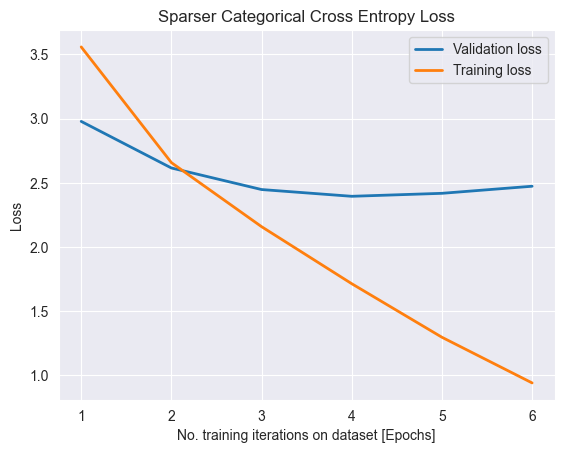

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

ax = plt.subplot(111) 
t = np.arange(1, epochs+1)

for i in range(0, len(vloss)):
  ax.cla()
  line1, = plt.plot(t[:i], vloss[:i], lw=2)
  line2, = plt.plot(t[:i], tloss[:i], lw=2)

ax.legend(["Validation loss", "Training loss"])
ax.set_title("Sparser Categorical Cross Entropy Loss")
ax.set_ylabel("Loss")
ax.set_xlabel("No. training iterations on dataset [Epochs]")



In [25]:
vloss[-1], tloss[-1]

(2.549233913421631, 0.6585878133773804)